In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

%matplotlib inline

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

print('Shape of training set:', mnist.train.images.shape)
print('Shape of training set labels:', mnist.train.labels.shape)
print('Shape of validation set:', mnist.validation.images.shape)
print('Shape of validation set labels:', mnist.validation.labels.shape)
print('Shape of test set:', mnist.test.images.shape)
print('Shape of test set labels:', mnist.test.labels.shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Shape of training set: (55000, 784)
Shape of training set labels: (55000, 10)
Shape of validation set: (5000, 784)
Shape of validation set labels: (5000, 10)
Shape of test set: (10000, 784)
Shape of test set labels: (10000, 10)


In [3]:
def create_placeholders():
    X = tf.placeholder(tf.float32, shape=(784, None))
    Y = tf.placeholder(tf.float32, shape=(None, 10))
    return X,Y

In [4]:
def initialize_parameters(layers_dims):
    L = len(layers_dims)
    parameters = {}
    for l in range(1, L):
        parameters['W' + str(l)] = tf.get_variable(shape=[layers_dims[l], layers_dims[l - 1]], initializer=tf.contrib.layers.xavier_initializer(seed=1), name='W' + str(l))
        parameters['b' + str(l)] = tf.get_variable(shape=[layers_dims[l], 1], initializer=tf.zeros_initializer(), name='b' + str(l))
    return parameters

In [5]:
def forward_propagation(X, parameters):
    L = len(parameters) // 2
    values = {}
    dropout = {}
    values['A0'] = X
    for l in range(1, L):
        values['Z' + str(l)] = tf.add(tf.matmul(parameters['W' + str(l)], values['A' + str(l - 1)]), parameters['b' + str(l)])
        values['A' + str(l)] = tf.nn.relu(values['Z' + str(l)])
    values['Z' + str(L)] = tf.add(tf.matmul(parameters['W' + str(L)], values['A' + str(L - 1)]), parameters['b' + str(L)])
    return values['Z' + str(L)]

In [6]:
def compute_cost(Y, Z):
    Z = tf.transpose(Z)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z, labels=Y))
    return cost

In [7]:
def model(X_train, Y_train, X_valid, Y_valid, layers_dims, learning_rate, epochs, minibatch_size=64, print_costs=False):    
    tf.reset_default_graph()
    m = X_train.shape[1]
    X, Y = create_placeholders()
    layers_dims = [784] + layers_dims + [10]
    parameters = initialize_parameters(layers_dims)
    Z = forward_propagation(X, parameters)
    cost = compute_cost(Y, Z)
    
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)
    costs = []
    num_minibatches = m // minibatch_size
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        initial_time = time.time()
        for num in range(epochs):
            permutation = np.random.RandomState(num).permutation(m)
            X_train, Y_train = X_train[:, permutation], Y_train[permutation, :].reshape(m, Y_train.shape[1])
            epoch_cost = 0
            for mb in range(num_minibatches):
                _, minibatch_cost = sess.run([optimizer, cost], feed_dict={X: X_train[:, mb * minibatch_size : (mb + 1) * minibatch_size], Y: Y_train[mb * minibatch_size : (mb + 1) * minibatch_size, :]})
                epoch_cost += minibatch_cost
            if print_costs and num % 50 == 0:
                print('Cost after epoch', num, '=', epoch_cost / num_minibatches)
            if print_costs and num > 1:
                costs.append(epoch_cost / num_minibatches)
        
        print("Time taken:", time.time()-initial_time, 'seconds')
        if print_costs:
            plt.plot(np.squeeze(costs))
            plt.xlabel('Epoch number')
            plt.ylabel('Cost')
            plt.show()
        
        parameters = sess.run(parameters)
        correct_predictions = tf.equal(tf.argmax(Y, axis=1), tf.argmax(Z))
        accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'))
        print('Training Accuracy:', accuracy.eval({X: X_train, Y: Y_train}))
        print('Validation Accuracy:', accuracy.eval({X: X_valid, Y: Y_valid}))
        
    return parameters

Cost after epoch 0 = 1.1027125390430823
Cost after epoch 50 = 0.04866497044216265
Cost after epoch 100 = 0.015487246796742463
Cost after epoch 150 = 0.00600465725123724
Cost after epoch 200 = 0.003020286954213904
Cost after epoch 250 = 0.001891599751973882
Cost after epoch 300 = 0.0013315142292175761
Cost after epoch 350 = 0.0010068814479591765
Time taken: 577.1882834434509 seconds


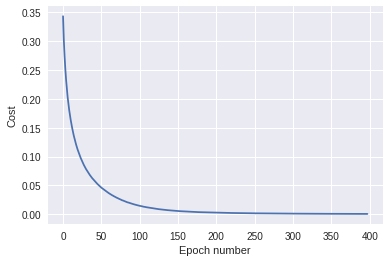

Training Accuracy: 1.0
Validation Accuracy: 0.977


In [8]:
parameters = model(mnist.train.images.T, mnist.train.labels, mnist.validation.images.T, mnist.validation.labels,learning_rate=0.01, layers_dims=[100, 20], epochs=400, print_costs=True)

In [9]:
def test(X_test, Y_test, parameters):
    X = tf.placeholder(tf.float32, shape=X_test.shape)
    Z = forward_propagation(X, parameters)
    correct_predictions = tf.equal(tf.argmax(Y_test, axis=1), tf.argmax(Z))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'))
    with tf.Session() as sess:
      	print('Test Accuracy:', accuracy.eval({X: X_test}))

test(mnist.test.images.T, mnist.test.labels, parameters)

Test Accuracy: 0.9764
